# Computational Finance

## Lab Assignment 2

This notebook makes use of a python 3 environment by default.

Authors:
- Kevin de Vries
- Jedda Boyle
- Krishnakanth Sasi

Student numbers:
- 10579869
- 11398221
- 11391952

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Basic Option Valuation

In [157]:
def MC_option_values(S0,K,r,sigma,T,M=1000,N_sim=1000,call=False,stats=True):
    """
    Calculates a number of European option 
    values using a Monte Carlo method.
    
    The value is determined as the mean of a 
    batch of payoffs discounted with the interest rate.
    
    Returns the mean of the calculated options and its standard error
    """
    eps = np.random.normal(0,1,(M,N_sim))
    S_T = S0 * np.exp((r - sigma**2 / 2)*T + sigma*eps*np.sqrt(T))
    batch = np.maximum(0, S_T - K) if call else np.maximum(0,K - S_T)
    
    values = np.exp(-r*T) * np.mean(batch,axis=0)
    
    if stats:
        mean,std = data_stats(values)
        return values,mean,std
    else:
        return values
    
def data_stats(data):
    mean = np.mean(data)
    var = np.sum((data-mean)**2) / (data.size - 1)
    std_err = np.sqrt(var/data.size)
    return mean,std_err

In [158]:
# Calculate European option value using Batch Monte Carlo
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, M = 1,20
N_sim = 2000000

# Option values and stats using mean payoffs
values,mean,std = MC_option_values(S0,K,r,sigma,T,M,N_sim)

print("Mean: %f" % mean)
print("Standard error: %f" % std)

Mean: 4.779484
Standard error: 0.001261


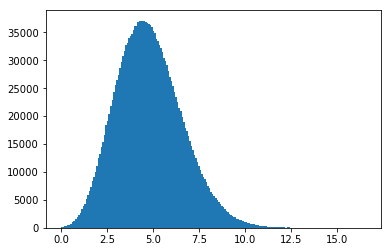

In [159]:
N_bins = 200

plt.hist(values,N_bins)
plt.show()

# Part 2: Estimation of Sensitivities in MC

In [160]:
# Calculate European option value using Batch Monte Carlo
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, M = 1,100
call = False

N_sim = 200000
eps = 0.5

# Option value and stats of unbumped
unbumped = MC_option_values(S0,K,r,sigma,T,M,N_sim,call)

# Option value and stats of bumped
bumped = MC_option_values(S0+eps,K,r,sigma,T,M,N_sim,call)

# Calculate delta from estimate means
deltas = (bumped[0]-unbumped[0]) / eps

mu_delta,std_delta = data_stats(deltas)

print("Mean: %f" % unbumped[1])
print("Standard error: %f\n" % unbumped[2])
print("Hedge parameter estimate: %f" % mu_delta)
print("Hedge parameter standard error: %f" % std_delta)

Mean: 4.781863
Standard error: 0.001785

Hedge parameter estimate: -0.324964
Hedge parameter standard error: 0.005008


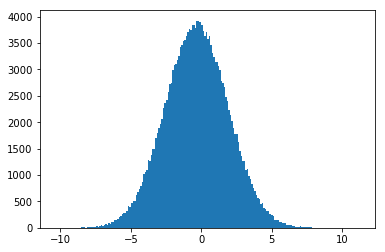

In [161]:
N_bins = 200

plt.hist(deltas,N_bins)
plt.show()

# Part 3: Variance Reduction